In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [7]:
print(tf.__version__)

1.13.1


In [8]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [9]:
import os
import numpy as np
import pandas as pd 
d ={"data":"datafile"}
train_name=next(os.walk("trainval datalist"))[2]
for i in range(len(train_name)):
    data = np.loadtxt('trainval datalist/'+train_name[i],dtype=np.str)
#    if "val" in train_name[i]:
#        type_file=".png"
#    else:
#        type_file=".jpg"
#    data=[i+type_file for i in data]
    d[train_name[i]] =data


In [10]:
def _read_to_tensor(fname, output_height=256, output_width=256, normalize_data=False):
    '''Function to read images from given image file path, and provide resized images as tensors
        Inputs: 
            fname - image file path
            output_height - required output image height
            output_width - required output image width
            normalize_data - if True, normalize data to be centered around 0 (mean 0, range 0 to 1)
        Output: Processed image tensors
    '''
    
    # Read the image as a tensor
    img_strings = tf.io.read_file(fname)
    imgs_decoded = tf.image.decode_jpeg(img_strings)
    
    # Resize the image
    output = tf.image.resize(imgs_decoded, [output_height, output_width])
    
    # Normalize if required
    if normalize_data:
        output = (output - 128) / 128
    return output

In [12]:
img_dir_tr='JPEGImages/'
img_dir_te='SegmentationClass/'
# Required image dimensions
output_height = 256
output_width = 256

In [13]:
def read_images(img_dir_tr,img_dir_te):
    frames_list=[fname+'.jpg' for fname in d["train.txt"]]
    masks_list=[fname+'.png' for fname in d["train.txt"]]
    frames_paths = [os.path.join(img_dir_tr, fname+'.jpg') for fname in d["train.txt"]]
    masks_paths = [os.path.join(img_dir_te, fname+'.png') for fname in d["train.txt"]]
    # Create dataset of tensors
    frame_data = tf.data.Dataset.from_tensor_slices(frames_paths)
    masks_data = tf.data.Dataset.from_tensor_slices(masks_paths)
    # Read images into the tensor dataset
    frame_tensors = frame_data.map(_read_to_tensor)
    masks_tensors = masks_data.map(_read_to_tensor)
    print('Completed importing {} frame images from the provided directory.'.format(len(frames_list)))
    print('Completed importing {} mask images from the provided directory.'.format(len(masks_list)))
    return frame_tensors, masks_tensors, frames_list, masks_list
    


frame_tensors, masks_tensors, frames_list, masks_list = read_images(img_dir_tr,img_dir_te)

Completed importing 1464 frame images from the provided directory.
Completed importing 1464 mask images from the provided directory.


Instructions for updating:
Colocations handled automatically by placer.


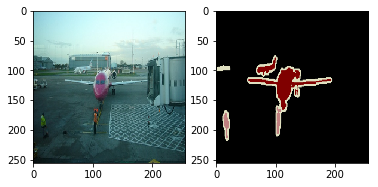

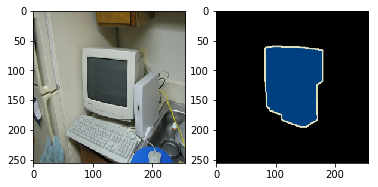

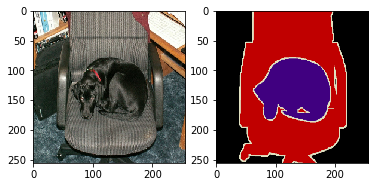

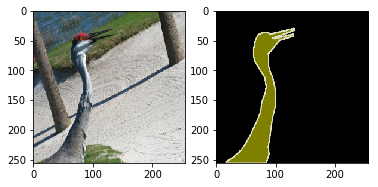

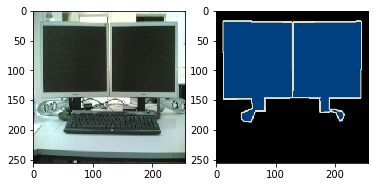

In [14]:
# Make an iterator to extract images from the tensor dataset
frame_batches = tf.compat.v1.data.make_one_shot_iterator(frame_tensors)  # outside of TF Eager, we would use make_one_shot_iterator
mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks_tensors)

n_images_to_show = 5

for i in range(n_images_to_show):
    
    # Get the next image from iterator
    frame = frame_batches.next().numpy().astype(np.uint8)
    mask = mask_batches.next().numpy().astype(np.uint8)
    
    #Plot the corresponding frames and masks
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(frame)
    fig.add_subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

In [15]:
DATA_PATH = 'data/CamSeq01/'

# Create folders to hold images and masks

folders = ['train_frames/train', 'train_masks/train', 'val_frames/val', 'val_masks/val']


for folder in folders:
    try:
        os.makedirs(DATA_PATH + folder)
    except Exception as e: print(e)

[WinError 183] 当文件已存在时，无法创建该文件。: 'data/CamSeq01/train_frames/train'
[WinError 183] 当文件已存在时，无法创建该文件。: 'data/CamSeq01/train_masks/train'
[WinError 183] 当文件已存在时，无法创建该文件。: 'data/CamSeq01/val_frames/val'
[WinError 183] 当文件已存在时，无法创建该文件。: 'data/CamSeq01/val_masks/val'


In [16]:
def generate_image_folder_structure(frames, masks, frames_list, masks_list):
    '''Function to save images in the appropriate folder directories 
        Inputs: 
            frames - frame tensor dataset
            masks - mask tensor dataset
            frames_list - frame file paths
            masks_list - mask file paths
    '''
    #Create iterators for frames and masks
    frame_batches = tf.compat.v1.data.make_one_shot_iterator(frames)  # outside of TF Eager, we would use make_one_shot_iterator
    mask_batches = tf.compat.v1.data.make_one_shot_iterator(masks)
    
    #Iterate over the train images while saving the frames and masks in appropriate folders
    dir_name='train'
    for file in zip(frames_list[:-round(0.2*len(frames_list))],masks_list[:-round(0.2*len(masks_list))]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    #Iterate over the val images while saving the frames and masks in appropriate folders
    dir_name='val'
    for file in zip(frames_list[-round(0.2*len(frames_list)):],masks_list[-round(0.2*len(masks_list)):]):
        
        
        #Convert tensors to numpy arrays
        frame = frame_batches.next().numpy().astype(np.uint8)
        mask = mask_batches.next().numpy().astype(np.uint8)
        
        #Convert numpy arrays to images
        frame = Image.fromarray(frame)
        mask = Image.fromarray(mask)
        
        #Save frames and masks to correct directories
        frame.save(DATA_PATH+'{}_frames/{}'.format(dir_name,dir_name)+'/'+file[0])
        mask.save(DATA_PATH+'{}_masks/{}'.format(dir_name,dir_name)+'/'+file[1])
    
    print("Saved {} frames to directory {}".format(len(frames_list),DATA_PATH))
    print("Saved {} masks to directory {}".format(len(masks_list),DATA_PATH))
    
generate_image_folder_structure(frame_tensors, masks_tensors, frames_list, masks_list)

#generate_image_folder_structure(train_frames, train_masks, val_files, 'val')

Saved 1464 frames to directory data/CamSeq01/
Saved 1464 masks to directory data/CamSeq01/


In [17]:
def parse_code(l):
    '''Function to parse lines in a text file, returns separated elements (label codes and names in this case)
    '''
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [18]:
#label_codes, label_names = zip(*[parse_code(l) for l in open(img_dir+"label_colors.txt")])
#label_codes, label_names = list(label_codes), list(label_names)
#label_codes[:5], label_names[:5]

In [19]:
label_names=['Aeroplane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Dining table','Dog','Horse','Motorbike','People','Potted plant','Sheep','Sofa','Train','TV/monitor']
label_codes=[(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
label_names,label_codes

(['Aeroplane',
  'Bicycle',
  'Bird',
  'Boat',
  'Bottle',
  'Bus',
  'Car',
  'Cat',
  'Chair',
  'Cow',
  'Dining table',
  'Dog',
  'Horse',
  'Motorbike',
  'People',
  'Potted plant',
  'Sheep',
  'Sofa',
  'Train',
  'TV/monitor'],
 [(128, 0, 0),
  (0, 128, 0),
  (128, 128, 0),
  (0, 0, 128),
  (128, 0, 128),
  (0, 128, 128),
  (128, 128, 128),
  (64, 0, 0),
  (192, 0, 0),
  (64, 128, 0),
  (192, 128, 0),
  (64, 0, 128),
  (192, 0, 128),
  (64, 128, 128),
  (192, 128, 128),
  (0, 64, 0),
  (128, 64, 0),
  (0, 192, 0),
  (128, 192, 0),
  (0, 64, 128)])

In [20]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}


In [21]:
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [22]:
id2code

{0: (128, 0, 0),
 1: (0, 128, 0),
 2: (128, 128, 0),
 3: (0, 0, 128),
 4: (128, 0, 128),
 5: (0, 128, 128),
 6: (128, 128, 128),
 7: (64, 0, 0),
 8: (192, 0, 0),
 9: (64, 128, 0),
 10: (192, 128, 0),
 11: (64, 0, 128),
 12: (192, 0, 128),
 13: (64, 128, 128),
 14: (192, 128, 128),
 15: (0, 64, 0),
 16: (128, 64, 0),
 17: (0, 192, 0),
 18: (128, 192, 0),
 19: (0, 64, 128)}

In [23]:
id2name

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'People',
 15: 'Potted plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'TV/monitor'}

In [24]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [20]:

# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

In [21]:
def TrainAugmentGenerator(seed = 1, batch_size = 3):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    DATA_PATH + 'train_frames/',
    batch_size = batch_size, seed = seed)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    DATA_PATH + 'train_masks/',
    batch_size = batch_size, seed = seed)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(seed = 1, batch_size = 3):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    DATA_PATH + 'val_frames/',
    batch_size = batch_size, seed = seed)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    DATA_PATH + 'val_masks/',
    batch_size = batch_size, seed = seed)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [22]:
def get_small_unet(n_filters = 20, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input(batch_shape=(3, 256, 256, 3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(20, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [23]:
model = get_small_unet(n_filters = 20)

Tensor("input_1:0", shape=(3, 256, 256, 3), dtype=float32)


In [24]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [26]:
smooth = 1

In [27]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['categorical_accuracy'])#tversky_loss,dice_coef,'accuracy'

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (3, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (3, 256, 256, 20)    560         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (3, 256, 256, 20)    80          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (3, 256, 256, 20)    3620        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_norm

In [29]:
#model.load_weights("model_100_epochs.h5")

In [30]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='camvid_model_150_epochs_checkpoint.h5', monitor='val_acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_loss', patience=10, verbose=1)
rp = ReduceLROnPlateau(min_lr=0.01) #rp = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.01, verbose=1)
callbacks = [tb, mc, es, rp]

In [31]:
batch_size = 3
steps_per_epoch = int(np.ceil(float(len(frames_list) - round(0.1*len(frames_list))) / float(batch_size)))
steps_per_epoch

440

In [32]:

validation_steps = int((float((round(0.1*len(frames_list)))) / float(batch_size)))
validation_steps

48

In [33]:
num_epochs = 100

In [34]:
# Train model

batch_size = 3
result = model.fit_generator(TrainAugmentGenerator(), steps_per_epoch=16,
                validation_data = ValAugmentGenerator(), 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks)
model.save_weights("camvid_model_150_epochs.h5", overwrite=True)

Found 1171 images belonging to 1 classes.
Epoch 1/100
Found 1171 images belonging to 1 classes.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
15/16 [===========================>..] - ETA: 0s - loss: 2.3408 - categorical_accuracy: 0.0612Found 293 images belonging to 1 classes.
Found 293 images belonging to 1 classes.
16/16 [==============================] - 19s 1s/step - loss: 2.3188 - categorical_accuracy: 0.0645 - val_loss: 2.5930 - val_categorical_accuracy: 0.0117
Epoch 2/100
16/16 [==============================] - 9s 589ms/step - loss: 2.3446 - categorical_accuracy: 0.0573 - val_loss: 6.6157 - val_categorical_accuracy: 0.0176
Epoch 3/100
16/16 [==============================] - 9s 554ms/step - loss: 2.4871 - categorical_accuracy: 0.0471 - val_loss: 6.0674 - val_categorical_accuracy: 0.2992
Epoch 4/100
16/16 [==============================] - 9s 551ms/step - loss: 2.0252 - categorical_accuracy: 0.0641 - 

In [35]:
# import tempfile
# import tensorflow as tf

# if tf.__version__.startswith('2.'):
#     create_file_writer = tf.summary.create_file_writer
# else:
#     tf.enable_eager_execution()
#     create_file_writer = tf.contrib.summary.create_file_writer

# dir = tempfile.mkdtemp('shared-writer-bug')
# w = create_file_writer(dir)
# w.close()  # succeeds, deletes old resource
# # 1) new SummaryWriter created w/ new resource (but same name)
# # 2) reassigning w deletes old SummaryWriter along w/ new resource (BUG)
# w = create_file_writer(dir)
# w.close()  # raises NotFoundError; new resource has been incorrectly deleted

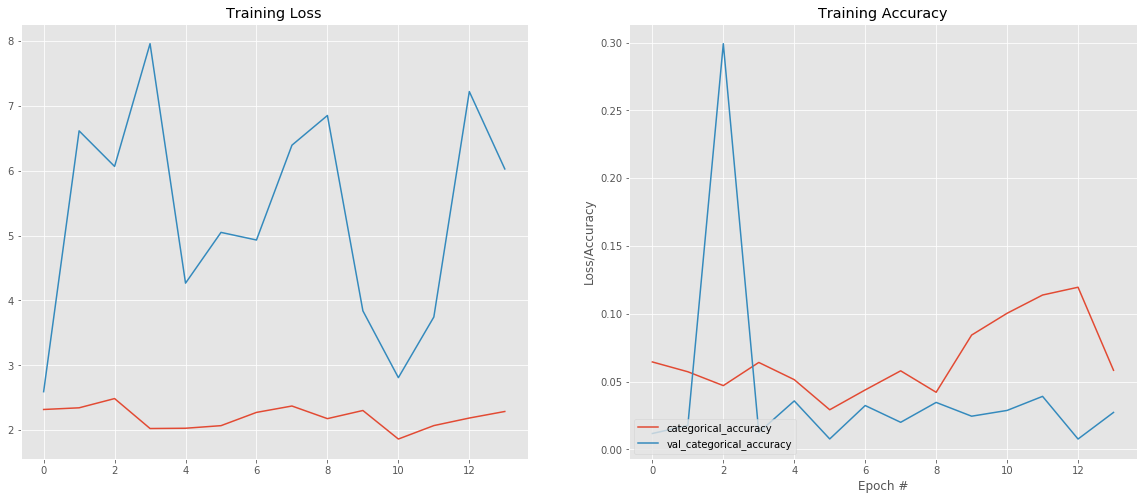

In [36]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
#plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot(np.arange(0, N), result.history["val_categorical_accuracy"], label="val_categorical_accuracy")
#plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [37]:
#training_gen = TrainAugmentGenerator()
testing_gen = ValAugmentGenerator()

In [38]:
batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

Found 293 images belonging to 1 classes.
Found 293 images belonging to 1 classes.


(3, 256, 256, 20)

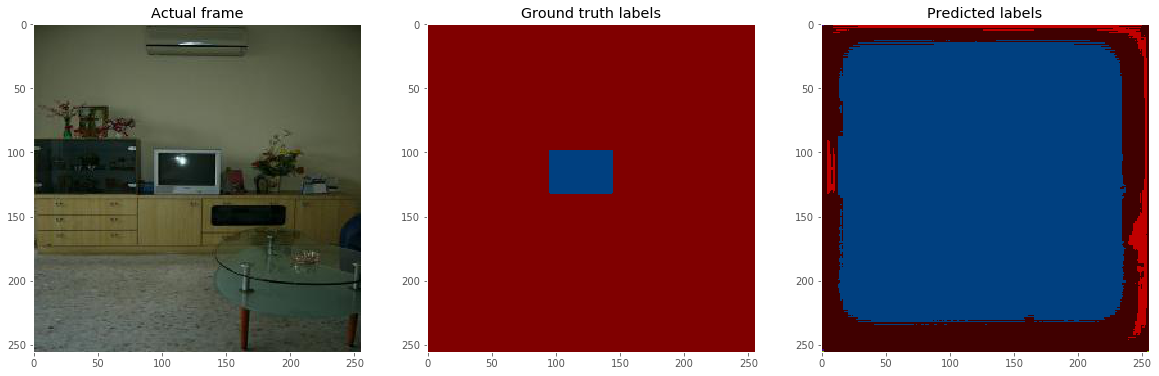

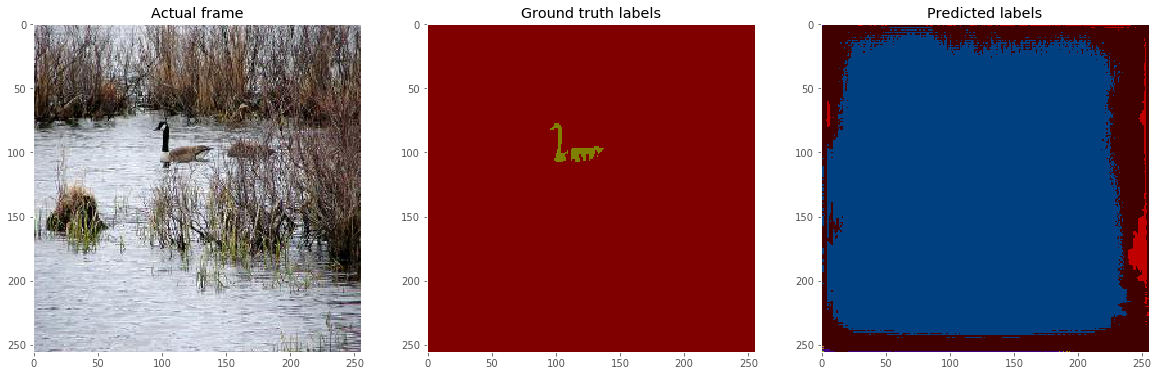

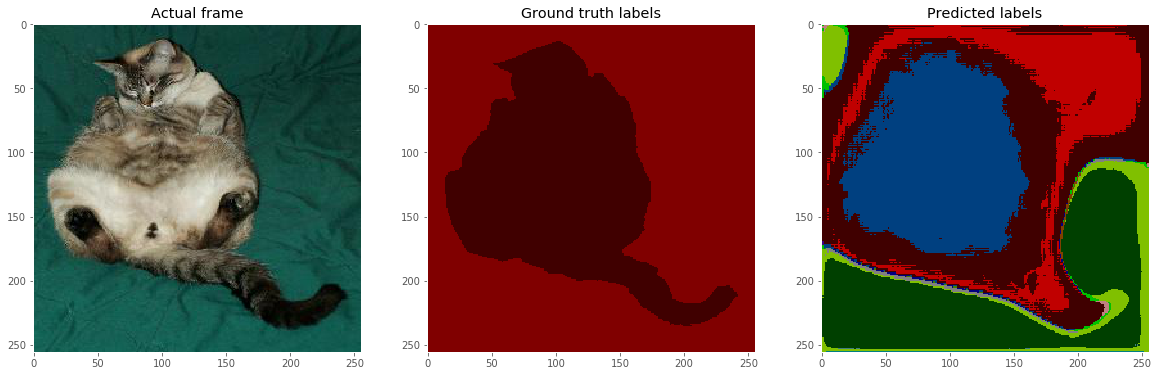

In [39]:
for i in range(0,np.shape(pred_all)[0]):
    
    fig = plt.figure(figsize=(20,8))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(batch_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    ax2.grid(b=None)
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[i],id2code))
    ax3.grid(b=None)
    
    plt.show()